# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


# Dataset Loading

In [21]:
train = pd.read_csv(r'D:\Project Phase II\Dataset\finaltrain.csv',encoding='cp1252')
test = pd.read_csv(r'D:\Project Phase II\Dataset\finaltest.csv',encoding='cp1252') #test_set1 
autrain = pd.read_csv(r'D:\Project Phase II\Dataset\UNSW_NB15_training-set.csv',encoding='cp1252') #train_set2
autest = pd.read_csv(r'D:\Project Phase II\Dataset\UNSW_NB15_testing-set.csv',encoding='cp1252') #test_set2

C:\Users\sathi\AppData\Local\Temp\ipykernel_10140\1785680868.py:1: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r'D:\Project Phase II\Dataset\finaltrain.csv',encoding='cp1252')
C:\Users\sathi\AppData\Local\Temp\ipykernel_10140\1785680868.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(r'D:\Project Phase II\Dataset\finaltest.csv',encoding='cp1252') #test_set1


# Input Transformation

## Training

In [7]:
nodes = set()
trainUnique = train
for i in range(len(train)):
    src = str(train['srcip'].iloc[i])+':'+ str(train['sport'].iloc[i]) + ':' + str(train['sttl'].iloc[i])+':'+str(train['swin'].iloc[i])
    dst = str(train['dstip'].iloc[i])+':'+str(train['dsport'].iloc[i]) + ':' + str(train['dttl'].iloc[i])+':'+str(train['dwin'].iloc[i])
    nodes.add(src)
    nodes.add(dst)


#Find unique (srcip,sport,dstip,dsport) tuples in train
train_tuples = set()
for i in range(len(train)):
    train_tuples.add((train['srcip'].iloc[i], train['sport'].iloc[i], train['dstip'].iloc[i], train['dsport'].iloc[i], train['sttl'].iloc[i], train['swin'].iloc[i], train['dttl'].iloc[i], train['dwin'].iloc[i]))

In [8]:
xLookUp = {}
x = []
count = 0
edge_index = []
edge_attr = []
for i in range(len(train)):
    src = str(train['srcip'].iloc[i])+':'+ str(train['sport'].iloc[i]) + ':' + str(train['sttl'].iloc[i])+':'+str(train['swin'].iloc[i])
    dst = str(train['dstip'].iloc[i])+':'+str(train['dsport'].iloc[i]) + ':' + str(train['dttl'].iloc[i])+':'+str(train['dwin'].iloc[i])
    if src not in xLookUp:
        xLookUp[src] = count
        # x.append([int(train['sport'].iloc[i]), int(train['sttl'].iloc[i]), int(train['swin'].iloc[i])])
        x.append([int(train['sttl'].iloc[i]), int(train['swin'].iloc[i])])
        count += 1
    if dst not in xLookUp:
        xLookUp[dst] = count
        # x.append([int(train['dsport'].iloc[i]), int(train['dttl'].iloc[i]), int(train['dwin'].iloc[i])])
        x.append([int(train['dttl'].iloc[i]), int(train['dwin'].iloc[i])])
        count += 1
    edge_index.append([xLookUp[src], xLookUp[dst]])
    edge_attr.append(list(train.iloc[i].drop(['srcip', 'sport', 'dstip', 'dsport', 'sttl', 'dttl','swin','dwin','Label']).values))


# Convert x to tensor
x_tensor = torch.tensor(x, dtype=torch.float)

# Convert edge_index to tensor
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t()  # Transpose for correct format

# Convert edge_attr to tensor
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

print(x_tensor.shape, edge_index_tensor.shape, edge_attr_tensor.shape)

torch.Size([97138, 2]) torch.Size([2, 79856]) torch.Size([79856, 20])


## Testing

In [9]:
testnodes = set()
testUnique = test
for i in range(len(test)):
    src = str(test['srcip'].iloc[i])+':'+ str(test['sport'].iloc[i]) + ':' + str(test['sttl'].iloc[i])+':'+str(test['swin'].iloc[i])
    dst = str(test['dstip'].iloc[i])+':'+str(test['dsport'].iloc[i]) + ':' + str(test['dttl'].iloc[i])+':'+str(test['dwin'].iloc[i])
    testnodes.add(src)
    testnodes.add(dst)


#Find unique (srcip,sport,dstip,dsport) tuples in train
test_tuples = set()
for i in range(len(test)):
    test_tuples.add((test['srcip'].iloc[i], test['sport'].iloc[i], test['dstip'].iloc[i], test['dsport'].iloc[i], test['sttl'].iloc[i], test['swin'].iloc[i], test['dttl'].iloc[i], test['dwin'].iloc[i]))

In [10]:
xtestLookUp = {}
xtest = []
count = 0
edge_index_test = []
edge_attr_test = []
for i in range(len(test)):
    src = str(test['srcip'].iloc[i])+':'+ str(test['sport'].iloc[i]) + ':' + str(test['sttl'].iloc[i])+':'+str(test['swin'].iloc[i])
    dst = str(test['dstip'].iloc[i])+':'+str(test['dsport'].iloc[i]) + ':' + str(test['dttl'].iloc[i])+':'+str(test['dwin'].iloc[i])
    if src not in xtestLookUp:
        xtestLookUp[src] = count
        # xtest.append([int(test['sport'].iloc[i]), int(test['sttl'].iloc[i]), int(test['swin'].iloc[i])])
        xtest.append([int(test['sttl'].iloc[i]), int(test['swin'].iloc[i])])
        count += 1
    if dst not in xtestLookUp:
        xtestLookUp[dst] = count
        # xtest.append([int(test['dsport'].iloc[i]), int(test['dttl'].iloc[i]), int(test['dwin'].iloc[i])])
        xtest.append([int(test['dttl'].iloc[i]), int(test['dwin'].iloc[i])])
        count += 1
    edge_index_test.append([xtestLookUp[src], xtestLookUp[dst]])
    edge_attr_test.append(list(test.iloc[i].drop(['srcip', 'sport', 'dstip', 'dsport', 'sttl', 'dttl','swin','dwin','Label']).values))


# Convert x to tensor
x_test_tensor = torch.tensor(xtest, dtype=torch.float)

# Convert edge_index to tensor
edge_index_test_tensor = torch.tensor(edge_index_test, dtype=torch.long).t()  # Transpose for correct format

# Convert edge_attr to tensor
edge_attr_test_tensor = torch.tensor(edge_attr_test, dtype=torch.float)

print(x_test_tensor.shape, edge_index_test_tensor.shape, edge_attr_test_tensor.shape)

torch.Size([42906, 2]) torch.Size([2, 34430]) torch.Size([34430, 20])


## Author's Training Dataset

Since srcip, sport, dstip, dsport information is not available, we proceed with having each node feature value as 0, and assume each edge as an unique connection between two imaginary nodes, we add stcpb and dtcpb as placeholders 

In [43]:
autrainnodes = set()
autrainUnique = autrain
for i in range(len(autrain)):
    src = str(autrain['sttl'].iloc[i])+':'+str(autrain['swin'].iloc[i]) + str(autrain['stcpb'].iloc[i]) + str(autrain['sbytes'].iloc[i]) + str(autrain['Sload'].iloc[i])+ str(autrain['Spkts'].iloc[i])+ str(autrain['smeansz'].iloc[i])+ str(autrain['Sjit'].iloc[i]) + str(autrain['Sintpkt'].iloc[i])
    dst = str(autrain['dttl'].iloc[i])+':'+str(autrain['dwin'].iloc[i]) + str(autrain['dtcpb'].iloc[i]) + str(autrain['dbytes'].iloc[i]) + str(autrain['Dload'].iloc[i])+ str(autrain['Dpkts'].iloc[i])+ str(autrain['dmeansz'].iloc[i])+ str(autrain['Djit'].iloc[i]) + str(autrain['Dintpkt'].iloc[i])
    autrainnodes.add(src)
    autrainnodes.add(dst)


#Find unique (srcip,sport,dstip,dsport) tuples in train
autrain_tuples = set()
for i in range(len(autrain)):
    autrain_tuples.add((autrain['sttl'].iloc[i], autrain['swin'].iloc[i], autrain['dttl'].iloc[i], autrain['dwin'].iloc[i], autrain['stcpb'].iloc[i], autrain['dtcpb'].iloc[i], autrain['sbytes'].iloc[i], autrain['dbytes'].iloc[i], autrain['Sload'].iloc[i], autrain['Dload'].iloc[i], autrain['Spkts'].iloc[i], autrain['Dpkts'].iloc[i], autrain['smeansz'].iloc[i], autrain['dmeansz'].iloc[i], autrain['Sjit'].iloc[i], autrain['Djit'].iloc[i], autrain['Sintpkt'].iloc[i], autrain['Dintpkt'].iloc[i]))

In [44]:
xautrainLookUp = {}
xautrain = []
count = 0
edge_index_autrain = []
edge_attr_autrain = []

for i in range(len(autrain)):
    src = str(autrain['sttl'].iloc[i])+':'+str(autrain['swin'].iloc[i]) + str(autrain['stcpb'].iloc[i]) + str(autrain['sbytes'].iloc[i]) + str(autrain['Sload'].iloc[i])+ str(autrain['Spkts'].iloc[i])+ str(autrain['smeansz'].iloc[i])+ str(autrain['Sjit'].iloc[i]) + str(autrain['Sintpkt'].iloc[i])
    dst = str(autrain['dttl'].iloc[i])+':'+str(autrain['dwin'].iloc[i]) + str(autrain['dtcpb'].iloc[i]) + str(autrain['dbytes'].iloc[i]) + str(autrain['Dload'].iloc[i])+ str(autrain['Dpkts'].iloc[i])+ str(autrain['dmeansz'].iloc[i])+ str(autrain['Djit'].iloc[i]) + str(autrain['Dintpkt'].iloc[i])
    if src not in xautrainLookUp:
        xautrainLookUp[src] = count
        # xautrain.append([0,int(autrain['sttl'].iloc[i]), int(autrain['swin'].iloc[i])])
        xautrain.append([int(autrain['sttl'].iloc[i]), int(autrain['swin'].iloc[i]), int(autrain['sbytes'].iloc[i]), int(autrain['Sload'].iloc[i]), int(autrain['Spkts'].iloc[i]), int(autrain['smeansz'].iloc[i]), int(autrain['Sjit'].iloc[i]), int(autrain['Sintpkt'].iloc[i])])
        count += 1
    if dst not in xautrainLookUp:
        xautrainLookUp[dst] = count
        # xautrain.append([0, int(autrain['dttl'].iloc[i]), int(autrain['dwin'].iloc[i])])
        xautrain.append([int(autrain['dttl'].iloc[i]), int(autrain['dwin'].iloc[i]), int(autrain['dbytes'].iloc[i]), int(autrain['Dload'].iloc[i]), int(autrain['Dpkts'].iloc[i]), int(autrain['dmeansz'].iloc[i]), int(autrain['Djit'].iloc[i]), int(autrain['Dintpkt'].iloc[i])])
        count += 1
    edge_index_autrain.append([xautrainLookUp[src], xautrainLookUp[dst]])
    edge_attr_autrain.append(list(autrain.iloc[i].drop(['sttl', 'dttl','swin','dwin','Label','stcpb','dtcpb', 'sbytes', 'dbytes', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'smeansz', 'dmeansz', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt']).values))



# Convert x to tensor
x_autrain_tensor = torch.tensor(xautrain, dtype=torch.float)

# Convert edge_index to tensor
edge_index_autrain_tensor = torch.tensor(edge_index_autrain, dtype=torch.long).t()  # Transpose for correct format

# Convert edge_attr to tensor
edge_attr_autrain_tensor = torch.tensor(edge_attr_autrain, dtype=torch.float)

print(x_autrain_tensor.shape, edge_index_autrain_tensor.shape, edge_attr_autrain_tensor.shape)

torch.Size([143841, 8]) torch.Size([2, 71930]) torch.Size([71930, 23])


## Author's Testing Dataset

In [45]:
autestnodes = set()
autestUnique = autest
for i in range(len(autest)):
    src = str(autest['sttl'].iloc[i])+':'+str(autest['swin'].iloc[i]) + str(autest['stcpb'].iloc[i]) + str(autest['sbytes'].iloc[i]) + str(autest['Sload'].iloc[i])+ str(autest['Spkts'].iloc[i])+ str(autest['smeansz'].iloc[i])+ str(autest['Sjit'].iloc[i]) + str(autest['Sintpkt'].iloc[i])
    dst = str(autest['dttl'].iloc[i])+':'+str(autest['dwin'].iloc[i]) + str(autest['dtcpb'].iloc[i]) + str(autest['dbytes'].iloc[i]) + str(autest['Dload'].iloc[i])+ str(autest['Dpkts'].iloc[i])+ str(autest['dmeansz'].iloc[i])+ str(autest['Djit'].iloc[i]) + str(autest['Dintpkt'].iloc[i])
    autestnodes.add(src)
    autestnodes.add(dst)


#Find unique (srcip,sport,dstip,dsport) tuples in train
autest_tuples = set()
for i in range(len(autest)):
    autest_tuples.add((autest['sttl'].iloc[i], autest['swin'].iloc[i], autest['dttl'].iloc[i], autest['dwin'].iloc[i], autest['stcpb'].iloc[i], autest['dtcpb'].iloc[i], autest['sbytes'].iloc[i], autest['dbytes'].iloc[i], autest['Sload'].iloc[i], autest['Dload'].iloc[i], autest['Spkts'].iloc[i], autest['Dpkts'].iloc[i], autest['smeansz'].iloc[i], autest['dmeansz'].iloc[i], autest['Sjit'].iloc[i], autest['Djit'].iloc[i], autest['Sintpkt'].iloc[i], autest['Dintpkt'].iloc[i]))

In [46]:
xautestLookUp = {}
xautest = []
count = 0
edge_index_autest = []
edge_attr_autest = []

for i in range(len(autest)):
    src = str(autest['sttl'].iloc[i])+':'+str(autest['swin'].iloc[i]) + str(autest['stcpb'].iloc[i]) + str(autest['sbytes'].iloc[i]) + str(autest['Sload'].iloc[i])+ str(autest['Spkts'].iloc[i])+ str(autest['smeansz'].iloc[i])+ str(autest['Sjit'].iloc[i]) + str(autest['Sintpkt'].iloc[i])
    dst = str(autest['dttl'].iloc[i])+':'+str(autest['dwin'].iloc[i]) + str(autest['dtcpb'].iloc[i]) + str(autest['dbytes'].iloc[i]) + str(autest['Dload'].iloc[i])+ str(autest['Dpkts'].iloc[i])+ str(autest['dmeansz'].iloc[i])+ str(autest['Djit'].iloc[i]) + str(autest['Dintpkt'].iloc[i])
    if src not in xautestLookUp:
        xautestLookUp[src] = count
        # xautest.append([0,int(autest['sttl'].iloc[i]), int(autest['swin'].iloc[i])])
        xautest.append([int(autest['sttl'].iloc[i]), int(autest['swin'].iloc[i]), int(autest['sbytes'].iloc[i]), int(autest['Sload'].iloc[i]), int(autest['Spkts'].iloc[i]), int(autest['smeansz'].iloc[i]), int(autest['Sjit'].iloc[i]), int(autest['Sintpkt'].iloc[i])])
        count += 1
    if dst not in xautestLookUp:
        xautestLookUp[dst] = count
        # xautest.append([0, int(autest['dttl'].iloc[i]), int(autest['dwin'].iloc[i])])
        xautest.append([int(autest['dttl'].iloc[i]), int(autest['dwin'].iloc[i]), int(autest['dbytes'].iloc[i]), int(autest['Dload'].iloc[i]), int(autest['Dpkts'].iloc[i]), int(autest['dmeansz'].iloc[i]), int(autest['Djit'].iloc[i]), int(autest['Dintpkt'].iloc[i])])
        count += 1
    edge_index_autest.append([xautestLookUp[src], xautestLookUp[dst]])
    edge_attr_autest.append(list(autest.iloc[i].drop(['sttl', 'dttl','swin','dwin','Label','stcpb','dtcpb', 'sbytes', 'dbytes', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'smeansz', 'dmeansz', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt']).values))



# Convert x to tensor
x_autest_tensor = torch.tensor(xautest, dtype=torch.float)

# Convert edge_index to tensor
edge_index_autest_tensor = torch.tensor(edge_index_autest, dtype=torch.long).t()  # Transpose for correct format

# Convert edge_attr to tensor
edge_attr_autest_tensor = torch.tensor(edge_attr_autest, dtype=torch.float)

print(x_autest_tensor.shape, edge_index_autest_tensor.shape, edge_attr_autest_tensor.shape)

torch.Size([54669, 8]) torch.Size([2, 27342]) torch.Size([27342, 23])


# GAT Model

## GAT Function Declaration

nn.Linear appplies linear transformation to the incoming data: y = x * transpose(A) + b 


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_heads, num_classes):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=num_heads, add_self_loops=False)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, add_self_loops=False)
        # self.edge_classifier = nn.Linear(hidden_channels * 2 * num_heads + num_edge_features, num_classes)
        self.edge_classifier = nn.Sequential(
        nn.Linear(hidden_channels * 2 * num_heads + num_edge_features, hidden_channels),  # Linear layer
        nn.ReLU(),  # ReLU activation function
        nn.Linear(hidden_channels, num_classes)  # Linear layer
        )

    def forward(self, x, edge_index, edge_attr):
        # Apply graph attentional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Concatenate node features with edge features
        num_edges = edge_index.size(1)
        node_x = x[edge_index[0]]
        node_x_other = x[edge_index[1]]
        edge_attr_padded = torch.cat([edge_attr, torch.zeros(num_edges - edge_attr.size(0), edge_attr.size(1))], dim=0)
        edge_x = torch.cat([node_x, node_x_other, edge_attr_padded], dim=1)

        # Classify edges into classes
        edge_scores = self.edge_classifier(edge_x)
        return edge_scores

## GAT-Training

In [15]:
# Example usage
num_nodes = len(nodes)
num_edges = len(train_tuples)
num_node_features = 2
num_edge_features = 20
hidden_channels = 16
num_heads = 32
num_classes = 26

# Instantiate GAT classifier
model = GATClassifier(num_node_features, num_edge_features, hidden_channels, num_heads, num_classes)

# Forward pass
edge_scores_train = model(x_tensor, edge_index_tensor, edge_attr_tensor)

## GAT-Testing

In [16]:
# Example usage
num_nodes_test = len(testnodes)
num_edges_test = len(test_tuples)

# Forward pass
edge_scores_test = model(x_test_tensor, edge_index_test_tensor, edge_attr_test_tensor)

## GAT-Author's training dataset

In [33]:
# Example usage
num_nodes_autrain = len(autrainnodes)
num_edges_autrain = len(autrain_tuples)

num_node_features = 8
num_edge_features = 23
hidden_channels = 16
num_heads = 16
num_classes = 39

# Instantiate GAT classifier
GATmodel = GATClassifier(num_node_features, num_edge_features, hidden_channels, num_heads, num_classes)
# Forward pass
edge_scores_autrain = GATmodel(x_autrain_tensor, edge_index_autrain_tensor, edge_attr_autrain_tensor)

## GAT-Author's testing dataset

In [34]:
# Example usage
num_nodes_autest = len(autestnodes)
num_edges_autest = len(autest_tuples)

# Forward pass
edge_scores_autest = GATmodel(x_autest_tensor, edge_index_autest_tensor, edge_attr_autest_tensor)

## Baseline Model: KNN

## KNN using User's train test

In [17]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
edge_scores_train_array = edge_scores_train.detach().numpy()
edge_scores_test_array = edge_scores_test.detach().numpy()
# Create a DataFrame from the NumPy array
columns = [str('Dim')+str(i) for i in range(edge_scores_train_array.shape[1])]
edge_scores_train_df = pd.DataFrame(edge_scores_train_array, columns=columns)
edge_scores_test_df = pd.DataFrame(edge_scores_test_array, columns=columns)
trainLabel = train['Label']
testLabel = test['Label']

NameError: name 'edge_scores_train' is not defined

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train = edge_scores_train_df
X_test = edge_scores_test_df
y_train = trainLabel
y_test = testLabel

# Initialize the KNN classifier
k = 10  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate accuracy
report = classification_report(y_test, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     17201
           1       0.99      1.00      0.99     17229

    accuracy                           0.99     34430
   macro avg       0.99      0.99      0.99     34430
weighted avg       0.99      0.99      0.99     34430



## Attack Sequence Trace Back

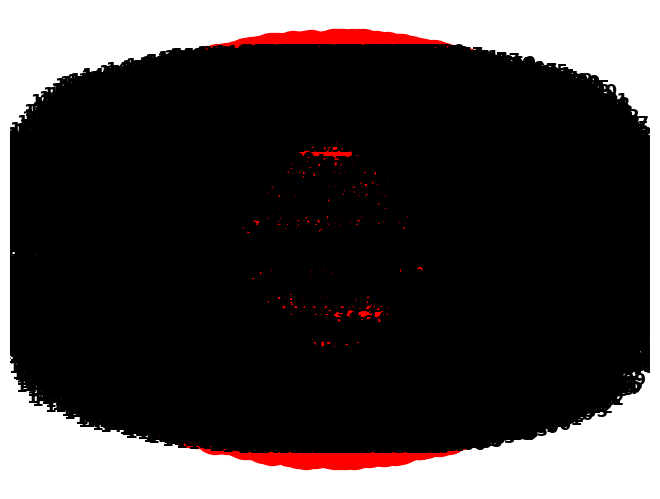

In [21]:
#Retrieve index positions of y_pred = 1
indices_of_ones = np.where(y_pred == 1)[0]

import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

# Create a directed graph
traceBackG = nx.DiGraph()

for i in indices_of_ones:
    src = str(testWithStimeLtime.iloc[i]['srcip']) + str(testWithStimeLtime.iloc[i]['sport'])
    dst = str(testWithStimeLtime.iloc[i]['dstip']) + str(testWithStimeLtime.iloc[i]['dsport'])
    traceBackG.add_node(src)
    traceBackG.add_node(dst)
    stime = datetime.fromtimestamp(testWithStimeLtime.iloc[i]['Stime']).strftime('%Y-%m-%d %H:%M:%S')
    ltime = datetime.fromtimestamp(testWithStimeLtime.iloc[i]['Ltime']).strftime('%Y-%m-%d %H:%M:%S')
    traceBackG.add_edge(src, dst, label="Connection Start Time: " + str(stime) + ", Connection End Time: "+ str(ltime))


# Draw the graph
pos = nx.spring_layout(traceBackG)  # Define layout
nx.draw(traceBackG, pos, with_labels=True, node_size=1000, node_color='red', font_size=12, font_weight='bold')
node_labels = nx.get_node_attributes(traceBackG, 'label')
nx.draw_networkx_labels(traceBackG, pos, labels=node_labels, font_size=12, font_weight='bold', font_color='black', 
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Show the plot
plt.show()

## KNN Training using User prepared dataset and Testing Using Author's test dataset

In [106]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
edge_scores_autest_array = edge_scores_autest.detach().numpy()
# Create a DataFrame from the NumPy array
#testLabeldf = pd.DataFrame(auEdgeLabel, columns=['Label'])
edge_scores_autest_df = pd.DataFrame(edge_scores_autest_array, columns=columns)
trainLabel = train['Label']
autestLabel = autest['Label']
auX_test = edge_scores_autest_df
auy_test = autestLabel 

auy_pred = knn_classifier.predict(edge_scores_autest_df)

# Calculate accuracy
report = classification_report(autestLabel, auy_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.92      0.77     24354
           1       0.49      0.13      0.21     13671

    accuracy                           0.64     38025
   macro avg       0.57      0.53      0.49     38025
weighted avg       0.59      0.64      0.56     38025



## KNN using author's training and testing dataset

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np


edge_scores_autrain_array = edge_scores_autrain.detach().numpy()
edge_scores_autest_array = edge_scores_autest.detach().numpy()

columns = [str('Dim')+str(i) for i in range(edge_scores_autrain_array.shape[1])]

edge_scores_autrain_df = pd.DataFrame(edge_scores_autrain_array, columns=columns)
edge_scores_autest_df = pd.DataFrame(edge_scores_autest_array, columns=columns)


trainLabel = autrain['Label']
autestLabel = autest['Label']
auX_train = edge_scores_autrain_df
auX_test = edge_scores_autest_df

# Initialize the KNN classifier
k = 10  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(auX_train, trainLabel)

# Predictions on the test set
y_pred = knn_classifier.predict(auX_test)

# Calculate accuracy
report = classification_report(autestLabel, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.62      0.74     24355
           1       0.57      0.90      0.70     13671

    accuracy                           0.72     38026
   macro avg       0.74      0.76      0.72     38026
weighted avg       0.79      0.72      0.72     38026



## Lazy Predict Scores

## User prepared train-test

In [24]:
# List of classifiers to include
import sklearn
import xgboost
import lightgbm
import sklearn.discriminant_analysis
from lazypredict.Supervised import LazyClassifier


classifiers = [
    ('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
    ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
    ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
    # ('ExtraTreeClassifier', sklearn.ensemble._forest.ExtraTreeClassifier),
    # ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
    # ('KNeighborsClassifier',  sklearn.neighbors._classification.KNeighborsClassifier),
    # ('NuSVC', sklearn.svm._classes.NuSVC),
    ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
    # ('SVC', sklearn.svm._classes.SVC),
    ('XGBClassifier', xgboost.sklearn.XGBClassifier),
    ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None,classifiers= classifiers, predictions=True)

models,predictions = clf.fit(X_train, X_test, y_train, y_test)


c:\ProgramData\Anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


NameError: name 'X_train' is not defined

In [56]:
from sklearn.metrics import roc_auc_score
for m in predictions.columns:
    print(m)
    print(classification_report(y_test, predictions[m]))
    auc_scores = roc_auc_score(y_test, predictions[m], multi_class='ovr')  # Or multi_class='ovo' for one-vs-one
    print("AUC Scores for each class:", auc_scores)
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     17201
           1       0.95      0.93      0.94     17229

    accuracy                           0.94     34430
   macro avg       0.94      0.94      0.94     34430
weighted avg       0.94      0.94      0.94     34430

AUC Scores for each class: 0.9422097027761159
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
BaggingClassifier
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     17201
           1       0.98      0.99      0.99     17229

    accuracy                           0.99     34430
   macro avg       0.99      0.99      0.99     34430
weighted avg       0.99      0.99      0.99     34430

AUC Scores for each class: 0.9885528935873277
-------------------------------------------------

## Lazy Predict for author's train-test dataset

In [82]:
# List of classifiers to include
import sklearn
import xgboost
import lightgbm
import sklearn.discriminant_analysis
from lazypredict.Supervised import LazyClassifier

classifiers = [
    ('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
    ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
    ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
    ('ExtraTreeClassifier', sklearn.ensemble._forest.ExtraTreeClassifier),
    ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
    ('KNeighborsClassifier',  sklearn.neighbors._classification.KNeighborsClassifier),
    # ('NuSVC', sklearn.svm._classes.NuSVC),
    ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
    # ('SVC', sklearn.svm._classes.SVC),
    ('XGBClassifier', xgboost.sklearn.XGBClassifier),
    ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None,classifiers= classifiers, predictions=True)

aumodels, aupredictions = clf.fit(auX_train, auX_test, autrainLabel, autestLabel)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 11%|█         | 1/9 [00:37<05:00, 37.55s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7603686635944701, 'Balanced Accuracy': 0.76036866359447, 'ROC AUC': 0.7603686635944701, 'F1 Score': 0.7571162114121398, 'Time taken': 37.54766798019409}


 22%|██▏       | 2/9 [01:46<06:33, 56.28s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.7503474508082802, 'Balanced Accuracy': 0.7503474508082804, 'ROC AUC': 0.7503474508082804, 'F1 Score': 0.7474191514567166, 'Time taken': 69.38176321983337}


 33%|███▎      | 3/9 [01:55<03:26, 34.43s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7145783044400555, 'Balanced Accuracy': 0.7145783044400555, 'ROC AUC': 0.7145783044400557, 'F1 Score': 0.7134548900978201, 'Time taken': 8.431199073791504}


 44%|████▍     | 4/9 [01:55<01:44, 20.95s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7188208616780045, 'Balanced Accuracy': 0.7188208616780045, 'ROC AUC': 0.7188208616780045, 'F1 Score': 0.718149944013278, 'Time taken': 0.2932446002960205}


 56%|█████▌    | 5/9 [02:07<01:10, 17.74s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.765050106063931, 'Balanced Accuracy': 0.765050106063931, 'ROC AUC': 0.765050106063931, 'F1 Score': 0.7570485880117437, 'Time taken': 12.051555633544922}


 67%|██████▋   | 6/9 [02:15<00:43, 14.47s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7625265159827371, 'Balanced Accuracy': 0.7625265159827372, 'ROC AUC': 0.7625265159827371, 'F1 Score': 0.7580404223665856, 'Time taken': 8.118009567260742}


 78%|███████▊  | 7/9 [04:09<01:33, 46.93s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7570404505888377, 'Balanced Accuracy': 0.7570404505888377, 'ROC AUC': 0.7570404505888378, 'F1 Score': 0.7486866256749836, 'Time taken': 113.74266767501831}


 89%|████████▉ | 8/9 [04:12<00:33, 33.01s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.7443127788749908, 'Balanced Accuracy': 0.7443127788749908, 'ROC AUC': 0.7443127788749909, 'F1 Score': 0.7379239827133904, 'Time taken': 3.2241477966308594}
[LightGBM] [Info] Number of positive: 36961, number of negative: 34967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 71928, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513861 -> initscore=0.055459
[LightGBM] [Info] Start training from score 0.055459


100%|██████████| 9/9 [04:15<00:00, 28.37s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7600029259015434, 'Balanced Accuracy': 0.7600029259015435, 'ROC AUC': 0.7600029259015434, 'F1 Score': 0.7513940763136099, 'Time taken': 2.5325968265533447}


In [83]:
from sklearn.metrics import roc_auc_score
for model in aupredictions.columns:
    print(model)
    print(classification_report(autestLabel, aupredictions[model]))
    auc_scores = roc_auc_score(autestLabel, aupredictions[model], multi_class='ovr')  # Or multi_class='ovo' for one-vs-one
    print("AUC Scores for each class:", auc_scores)
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.84      0.64      0.73     13671
           1       0.71      0.88      0.79     13671

    accuracy                           0.76     27342
   macro avg       0.78      0.76      0.76     27342
weighted avg       0.78      0.76      0.76     27342

AUC Scores for each class: 0.7603686635944701
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
BaggingClassifier
              precision    recall  f1-score   support

           0       0.82      0.64      0.72     13671
           1       0.71      0.86      0.77     13671

    accuracy                           0.75     27342
   macro avg       0.76      0.75      0.75     27342
weighted avg       0.76      0.75      0.75     27342

AUC Scores for each class: 0.7503474508082804
-------------------------------------------------

In [111]:
aumodels

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.75,0.79,0.79,0.75,14.69
XGBClassifier,0.72,0.77,0.77,0.72,2.08
BaggingClassifier,0.72,0.77,0.77,0.73,48.16
ExtraTreesClassifier,0.71,0.77,0.77,0.71,15.07
RandomForestClassifier,0.71,0.77,0.77,0.71,95.48
SVC,0.70,0.77,0.77,0.70,322.21
LGBMClassifier,0.70,0.77,0.77,0.70,1.76
ExtraTreeClassifier,0.72,0.75,0.75,0.72,0.29
AdaBoostClassifier,0.68,0.75,0.75,0.68,32.22


# GCN

## GCN Model Definition

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_classes):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.edge_classifier = nn.Linear(hidden_channels * 2 + num_edge_features, num_classes)
        self.edge_classifier = nn.Sequential(
        nn.Linear(hidden_channels * 2 + num_edge_features, hidden_channels),  # Linear layer
        nn.ReLU(),  # ReLU activation function
        nn.Linear(hidden_channels, num_classes)  # Linear layer
        )


    def forward(self, x, edge_index, edge_attr):
        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Concatenate node features with edge features
        num_edges = edge_index.size(1)
        node_x = x[edge_index[0]]
        node_x_other = x[edge_index[1]]
        edge_attr_padded = torch.cat([edge_attr, torch.zeros(num_edges - edge_attr.size(0), edge_attr.size(1))], dim=0)
        edge_x = torch.cat([node_x, node_x_other, edge_attr_padded], dim=1)

        # Classify edges into classes
        edge_scores = self.edge_classifier(edge_x)
        return edge_scores

## GCN-Training using user prepared dataset

In [117]:
num_nodes = len(nodes)
num_edges = len(train_tuples)
num_node_features = 2
num_edge_features = 20
hidden_channels = 8
num_classes = 26

GCNmodel1 = GCNClassifier(num_node_features, num_edge_features, hidden_channels, num_classes)


GCNedge_scores_train = GCNmodel1(x_tensor, edge_index_tensor, edge_attr_tensor)

## GCN-Testing with user prepared dataset

In [118]:
num_nodes_test = len(testnodes)
num_edges_test = len(test_tuples)

# Forward pass
GCNedge_scores_test = GCNmodel1(x_test_tensor, edge_index_test_tensor, edge_attr_test_tensor)

## GCN-Training using Author's Train set

In [48]:
num_nodes_autrain = len(autrainnodes)
num_edges_autrain = len(autrain_tuples)
num_node_features = 8
num_edge_features = 23
hidden_channels = 8
num_classes = 64

GCNmodel2 = GCNClassifier(num_node_features, num_edge_features, hidden_channels, num_classes)
GCNedge_scores_autrain = GCNmodel2(x_autrain_tensor, edge_index_autrain_tensor, edge_attr_autrain_tensor)

## GCN-Testing using Author's Test set

In [49]:
# Example usage
num_nodes_autest = len(autestnodes)
num_edges_autest = len(autest_tuples)


# Forward pass
GCNedge_scores_autest = GCNmodel2(x_autest_tensor, edge_index_autest_tensor, edge_attr_autest_tensor)

## Baseline Model: KNN

## KNN using User's train-test

In [121]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
GCNedge_scores_train_array = GCNedge_scores_train.detach().numpy()
GCNedge_scores_test_array = GCNedge_scores_test.detach().numpy()
# Create a DataFrame from the NumPy array
columns = [str('Dim')+str(i) for i in range(GCNedge_scores_train_array.shape[1])]
GCNedge_scores_train_df = pd.DataFrame(GCNedge_scores_train_array, columns=columns)
GCNedge_scores_test_df = pd.DataFrame(GCNedge_scores_test_array, columns=columns)
trainLabel = train['Label']
testLabel = test['Label']

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

GCNX_train = GCNedge_scores_train_df
GCNX_test = GCNedge_scores_test_df
y_train = trainLabel
y_test = testLabel

# Initialize the KNN classifier
k = 10  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(GCNX_train, y_train)

# Predictions on the test set
y_pred = knn_classifier.predict(GCNX_test)

# Calculate accuracy
report = classification_report(y_test, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     17201
           1       0.99      1.00      0.99     17229

    accuracy                           0.99     34430
   macro avg       0.99      0.99      0.99     34430
weighted avg       0.99      0.99      0.99     34430



## KNN training using user's dataset and testing using author's test dataset

In [48]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
GCNedge_scores_autest_array = GCNedge_scores_autest.detach().numpy()
# Create a DataFrame from the NumPy array
#testLabeldf = pd.DataFrame(auEdgeLabel, columns=['Label'])
GCNedge_scores_autest_df = pd.DataFrame(GCNedge_scores_autest_array, columns=columns)
trainLabel = train['Label']
autestLabel = autest['Label']
auX_test = GCNedge_scores_autest_df
auy_test = autestLabel 

auy_pred = knn_classifier.predict(GCNedge_scores_autest_df)

# Calculate accuracy
report = classification_report(autestLabel, auy_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.40      0.48     24354
           1       0.32      0.50      0.39     13671

    accuracy                           0.44     38025
   macro avg       0.45      0.45      0.43     38025
weighted avg       0.49      0.44      0.45     38025



## KNN using Author's train-test Set

In [50]:
GCNedge_scores_autrain_array = GCNedge_scores_autrain.detach().numpy()
GCNedge_scores_autest_array = GCNedge_scores_autest.detach().numpy()

columns = [str('Dim')+str(i) for i in range(GCNedge_scores_autrain_array.shape[1])]

GCNedge_scores_autrain_df = pd.DataFrame(GCNedge_scores_autrain_array, columns=columns)
GCNedge_scores_autest_df = pd.DataFrame(GCNedge_scores_autest_array, columns=columns)


trainLabel = autrain['Label']
autestLabel = autest['Label']
auX_train = GCNedge_scores_autrain_df
auX_test = GCNedge_scores_autest_df

# Initialize the KNN classifier
k = 10  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(auX_train, trainLabel)
# # Get training score
# training_score = knn_classifier.score(auX_train, trainLabel)
# print("Training score:", training_score)
# # Predictions on the test set
# y_predtrain = knn_classifier.predict(auX_train)

# # Calculate accuracy
# report = classification_report(trainLabel, y_predtrain)
# print("Classification Report for Training: \n", report)

# Predictions on the test set
y_pred = knn_classifier.predict(auX_test)

# Calculate accuracy
report = classification_report(autestLabel, y_pred)
print("Classification Report: \n", report)

Training score: 0.8979424440428194
Classification Report for Training: 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89     34968
           1       0.89      0.92      0.90     36962

    accuracy                           0.90     71930
   macro avg       0.90      0.90      0.90     71930
weighted avg       0.90      0.90      0.90     71930

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.67      0.72     13671
           1       0.71      0.83      0.77     13671

    accuracy                           0.75     27342
   macro avg       0.75      0.75      0.75     27342
weighted avg       0.75      0.75      0.75     27342



## Lazy Predict

In [62]:
# List of classifiers to include
import sklearn
import xgboost
import lightgbm
import sklearn.discriminant_analysis
from lazypredict.Supervised import LazyClassifier

classifiers = [
    ('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
    ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
    ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
    ('ExtraTreeClassifier', sklearn.ensemble._forest.ExtraTreeClassifier),
    ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
    ('KNeighborsClassifier',  sklearn.neighbors._classification.KNeighborsClassifier),
    # ('NuSVC', sklearn.svm._classes.NuSVC),
    ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
    # ('SVC', sklearn.svm._classes.SVC),
    ('XGBClassifier', xgboost.sklearn.XGBClassifier),
    ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None,classifiers= classifiers, predictions=True)

aumodels, aupredictions = clf.fit(auX_train, auX_test, autrainLabel, autestLabel)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:38<05:11, 38.88s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6909664694280079, 'Balanced Accuracy': 0.74793283866567, 'ROC AUC': 0.7479328386656698, 'F1 Score': 0.6915890668771454, 'Time taken': 38.87804198265076}


 22%|██▏       | 2/9 [02:00<07:29, 64.22s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.7342800788954635, 'Balanced Accuracy': 0.7655749788491162, 'ROC AUC': 0.7655749788491162, 'F1 Score': 0.7392171279577285, 'Time taken': 81.96214246749878}


 33%|███▎      | 3/9 [02:08<03:51, 38.51s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7233925049309665, 'Balanced Accuracy': 0.7422513752737423, 'ROC AUC': 0.7422513752737423, 'F1 Score': 0.7289618599317376, 'Time taken': 7.9221649169921875}


 44%|████▍     | 4/9 [02:09<01:57, 23.43s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.716397107166338, 'Balanced Accuracy': 0.7424374879134911, 'ROC AUC': 0.7424374879134911, 'F1 Score': 0.7218959494893769, 'Time taken': 0.3050239086151123}


 56%|█████▌    | 5/9 [02:20<01:16, 19.04s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7200788954635109, 'Balanced Accuracy': 0.7730826437974916, 'ROC AUC': 0.7730826437974916, 'F1 Score': 0.7220966178843252, 'Time taken': 11.249109268188477}


 67%|██████▋   | 6/9 [02:30<00:47, 15.96s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7327021696252466, 'Balanced Accuracy': 0.7725733412200761, 'ROC AUC': 0.7725733412200761, 'F1 Score': 0.7368590326396462, 'Time taken': 9.983182430267334}


 78%|███████▊  | 7/9 [03:53<01:15, 37.84s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7145036160420776, 'Balanced Accuracy': 0.7681847051578421, 'ROC AUC': 0.7681847051578421, 'F1 Score': 0.7163148141757488, 'Time taken': 82.87541651725769}


 89%|████████▉ | 8/9 [03:55<00:26, 26.44s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.7312031558185405, 'Balanced Accuracy': 0.7740181537809951, 'ROC AUC': 0.7740181537809951, 'F1 Score': 0.734994716364209, 'Time taken': 2.051447868347168}
[LightGBM] [Info] Number of positive: 36961, number of negative: 34967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 71928, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513861 -> initscore=0.055459
[LightGBM] [Info] Start training from score 0.055459


100%|██████████| 9/9 [03:57<00:00, 26.35s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7172123602892834, 'Balanced Accuracy': 0.77493584993304, 'ROC AUC': 0.7749358499330399, 'F1 Score': 0.7181436751183073, 'Time taken': 1.936528205871582}


In [63]:
from sklearn.metrics import roc_auc_score
for model in aupredictions.columns:
    print(model)
    print(classification_report(autestLabel, aupredictions[model]))
    auc_scores = roc_auc_score(autestLabel, aupredictions[model], multi_class='ovr')  # Or multi_class='ovo' for one-vs-one
    print("AUC Scores for each class:", auc_scores)
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.95      0.55      0.69     24354
           1       0.54      0.95      0.69     13671

    accuracy                           0.69     38025
   macro avg       0.75      0.75      0.69     38025
weighted avg       0.80      0.69      0.69     38025

AUC Scores for each class: 0.7479328386656698
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
BaggingClassifier
              precision    recall  f1-score   support

           0       0.90      0.65      0.76     24354
           1       0.59      0.88      0.70     13671

    accuracy                           0.73     38025
   macro avg       0.75      0.77      0.73     38025
weighted avg       0.79      0.73      0.74     38025

AUC Scores for each class: 0.7655749788491162
-------------------------------------------------

In [53]:
aumodels

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.76,0.80,0.80,0.77,1.76
ExtraTreesClassifier,0.74,0.78,0.78,0.74,11.78
KNeighborsClassifier,0.75,0.78,0.78,0.76,11.70
RandomForestClassifier,0.74,0.78,0.78,0.74,77.61
XGBClassifier,0.75,0.78,0.78,0.75,1.67
BaggingClassifier,0.75,0.77,0.77,0.76,52.12
ExtraTreeClassifier,0.73,0.75,0.75,0.73,0.27
DecisionTreeClassifier,0.72,0.74,0.74,0.73,5.31
AdaBoostClassifier,0.67,0.72,0.72,0.67,27.68


# GraphSAGE

## GraphSAGE Model Declaration

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
class GraphSAGEClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_classes):
        super(GraphSAGEClassifier, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.edge_classifier = nn.Linear(hidden_channels * 2 + num_edge_features, num_classes)

    def forward(self, x, edge_index, edge_attr):
        # Apply GraphSAGE convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Concatenate node features with edge features
        num_edges = edge_index.size(1)
        node_x = x[edge_index[0]]
        node_x_other = x[edge_index[1]]
        edge_attr_padded = torch.cat([edge_attr, torch.zeros(num_edges - edge_attr.size(0), edge_attr.size(1))], dim=0)
        edge_x = torch.cat([node_x, node_x_other, edge_attr_padded], dim=1)

        # Classify edges into binary class using BCELogit
        edge_scores = self.edge_classifier(edge_x)
        return edge_scores

## GraphSAGE- User's train-test

In [130]:
num_nodes = len(nodes)
num_edges = len(train_tuples)
num_node_features = 2
num_edge_features = 20
hidden_channels = 8
num_classes = 26

GraphSAGEmodel1 = GraphSAGEClassifier(num_node_features, num_edge_features, hidden_channels, num_classes)


GraphSAGEedge_scores_train = GraphSAGEmodel1(x_tensor, edge_index_tensor, edge_attr_tensor)

In [131]:
num_nodes_test = len(testnodes)
num_edges_test = len(test_tuples)

# Forward pass
GraphSAGEedge_scores_test = GraphSAGEmodel1(x_test_tensor, edge_index_test_tensor, edge_attr_test_tensor)

## GraphSAGE-Author's train-test

In [123]:
num_nodes_autrain = len(autrainnodes)
num_edges_autrain = len(autrain_tuples)
num_node_features = 8
num_edge_features = 23
hidden_channels = 8
num_classes = 39

GraphSAGEmodel2 = GraphSAGEClassifier(num_node_features, num_edge_features, hidden_channels, num_classes)
GraphSAGEedge_scores_autrain = GraphSAGEmodel2(x_autrain_tensor, edge_index_autrain_tensor, edge_attr_autrain_tensor)

In [124]:
num_nodes_autest = len(autestnodes)
num_edges_autest = len(autest_tuples)


# Forward pass
GraphSAGEedge_scores_autest = GraphSAGEmodel2(x_autest_tensor, edge_index_autest_tensor, edge_attr_autest_tensor)

## Baseline Model: KNN

## KNN using User's train-test

In [134]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
GraphSAGEedge_scores_train_array = GraphSAGEedge_scores_train.detach().numpy()
GraphSAGEedge_scores_test_array = GraphSAGEedge_scores_test.detach().numpy()
# Create a DataFrame from the NumPy array
columns = [str('Dim')+str(i) for i in range(GraphSAGEedge_scores_train_array.shape[1])]
GraphSAGEedge_scores_train_df = pd.DataFrame(GraphSAGEedge_scores_train_array, columns=columns)
GraphSAGEedge_scores_test_df = pd.DataFrame(GraphSAGEedge_scores_test_array, columns=columns)
trainLabel = train['Label']
testLabel = test['Label']

In [135]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

GraphSAGEX_train = GraphSAGEedge_scores_train_df
GraphSAGEX_test = GraphSAGEedge_scores_test_df
y_train = trainLabel
y_test = testLabel

# Initialize the KNN classifier
k = 10  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(GraphSAGEX_train, y_train)

# Predictions on the test set
y_pred = knn_classifier.predict(GraphSAGEX_test)

# Calculate accuracy
report = classification_report(y_test, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     17201
           1       0.99      1.00      0.99     17229

    accuracy                           0.99     34430
   macro avg       0.99      0.99      0.99     34430
weighted avg       0.99      0.99      0.99     34430



## Training using user's dataset but testing using author's test set

In [ ]:
import pandas as pd
# Convert edge_scores tensor to a NumPy array
GraphSAGEedge_scores_autest_array = GraphSAGEedge_scores_autest.detach().numpy()
# Create a DataFrame from the NumPy array
#testLabeldf = pd.DataFrame(auEdgeLabel, columns=['Label'])
GraphSAGEedge_scores_autest_df = pd.DataFrame(GraphSAGEedge_scores_autest_array, columns=columns)
trainLabel = train['Label']
autestLabel = autest['Label']
auX_test = GraphSAGEedge_scores_autest_df
auy_test = autestLabel 

auy_pred = knn_classifier.predict(GraphSAGEedge_scores_autest_df)

# Calculate accuracy
report = classification_report(autestLabel, auy_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.99      0.78     24354
           1       0.73      0.05      0.09     13671

    accuracy                           0.65     38025
   macro avg       0.69      0.52      0.44     38025
weighted avg       0.68      0.65      0.53     38025



## KNN Author's train-test

In [127]:
GraphSAGEedge_scores_autrain_array = GraphSAGEedge_scores_autrain.detach().numpy()
GraphSAGEedge_scores_autest_array = GraphSAGEedge_scores_autest.detach().numpy()

GraphSAGEedge_scores_autrain_df = pd.DataFrame(GraphSAGEedge_scores_autrain_array, columns=columns)
GraphSAGEedge_scores_autest_df = pd.DataFrame(GraphSAGEedge_scores_autest_array, columns=columns)


trainLabel = autrain['Label']
autestLabel = autest['Label']
auX_train = GraphSAGEedge_scores_autrain_df
auX_test = GraphSAGEedge_scores_autest_df

# Initialize the KNN classifier
k = 15  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn_classifier.fit(auX_train, trainLabel)

# Predictions on the test set
y_pred = knn_classifier.predict(auX_test)

# Calculate accuracy
report = classification_report(autestLabel, y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.61      0.74     24354
           1       0.57      0.93      0.71     13671

    accuracy                           0.73     38025
   macro avg       0.76      0.77      0.72     38025
weighted avg       0.81      0.73      0.73     38025



## Lazy Predict

In [128]:
# List of classifiers to include
import sklearn
import xgboost
import lightgbm
import sklearn.discriminant_analysis
from lazypredict.Supervised import LazyClassifier

classifiers = [
    ('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
    ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
    ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
    ('ExtraTreeClassifier', sklearn.ensemble._forest.ExtraTreeClassifier),
    ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
    ('KNeighborsClassifier',  sklearn.neighbors._classification.KNeighborsClassifier),
    # ('NuSVC', sklearn.svm._classes.NuSVC),
    ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
    # ('SVC', sklearn.svm._classes.SVC),
    ('XGBClassifier', xgboost.sklearn.XGBClassifier),
    ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None,classifiers= classifiers, predictions=True)

aumodels, aupredictions = clf.fit(auX_train, auX_test, autrainLabel, autestLabel)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 11%|█         | 1/9 [00:44<05:53, 44.22s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7001972386587771, 'Balanced Accuracy': 0.7443098459452286, 'ROC AUC': 0.7443098459452286, 'F1 Score': 0.7037813465241115, 'Time taken': 44.21695137023926}


 22%|██▏       | 2/9 [02:12<08:09, 69.92s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.7233399079552926, 'Balanced Accuracy': 0.750745329086343, 'ROC AUC': 0.7507453290863428, 'F1 Score': 0.7286644247604802, 'Time taken': 87.90462803840637}


 33%|███▎      | 3/9 [02:22<04:17, 42.89s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7154503616042077, 'Balanced Accuracy': 0.736708935455704, 'ROC AUC': 0.736708935455704, 'F1 Score': 0.7211395037559191, 'Time taken': 10.728997707366943}


 44%|████▍     | 4/9 [02:23<02:10, 26.12s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.7118474687705457, 'Balanced Accuracy': 0.7300619164449669, 'ROC AUC': 0.7300619164449669, 'F1 Score': 0.7176476369336533, 'Time taken': 0.408003568649292}


 56%|█████▌    | 5/9 [02:41<01:32, 23.19s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7103221564760026, 'Balanced Accuracy': 0.761230404312342, 'ROC AUC': 0.7612304043123421, 'F1 Score': 0.7126738460981523, 'Time taken': 17.987996578216553}


 67%|██████▋   | 6/9 [02:56<01:01, 20.34s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7306245890861276, 'Balanced Accuracy': 0.7656250684237647, 'ROC AUC': 0.7656250684237645, 'F1 Score': 0.7353062729278346, 'Time taken': 14.815185785293579}


 78%|███████▊  | 7/9 [04:52<01:43, 51.77s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7107166337935569, 'Balanced Accuracy': 0.7614741888935437, 'ROC AUC': 0.7614741888935438, 'F1 Score': 0.7131028794041027, 'Time taken': 116.48068380355835}


 89%|████████▉ | 8/9 [04:55<00:36, 36.17s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.7050361604207758, 'Balanced Accuracy': 0.7488735792658463, 'ROC AUC': 0.7488735792658464, 'F1 Score': 0.7086800205245375, 'Time taken': 2.7679989337921143}
[LightGBM] [Info] Number of positive: 36961, number of negative: 34967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 71928, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513861 -> initscore=0.055459
[LightGBM] [Info] Start training from score 0.055459


100%|██████████| 9/9 [04:57<00:00, 33.08s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.7034845496383958, 'Balanced Accuracy': 0.7573363656312965, 'ROC AUC': 0.7573363656312966, 'F1 Score': 0.7051103880781131, 'Time taken': 2.4149880409240723}


In [131]:
from sklearn.metrics import roc_auc_score
for model in aupredictions.columns:
    print(model)
    print(classification_report(autestLabel, aupredictions[model]))
    auc_scores = roc_auc_score(autestLabel, aupredictions[model], multi_class='ovr')  # Or multi_class='ovo' for one-vs-one
    print("AUC Scores for each class:", auc_scores)
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.91      0.59      0.72     24354
           1       0.55      0.90      0.68     13671

    accuracy                           0.70     38025
   macro avg       0.73      0.74      0.70     38025
weighted avg       0.78      0.70      0.70     38025

AUC Scores for each class: 0.7443098459452286
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
BaggingClassifier
              precision    recall  f1-score   support

           0       0.88      0.65      0.75     24354
           1       0.58      0.85      0.69     13671

    accuracy                           0.72     38025
   macro avg       0.73      0.75      0.72     38025
weighted avg       0.77      0.72      0.73     38025

AUC Scores for each class: 0.7507453290863428
-------------------------------------------------

In [130]:
aumodels

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.73,0.77,0.77,0.74,14.82
RandomForestClassifier,0.71,0.76,0.76,0.71,116.48
ExtraTreesClassifier,0.71,0.76,0.76,0.71,17.99
LGBMClassifier,0.70,0.76,0.76,0.71,2.41
BaggingClassifier,0.72,0.75,0.75,0.73,87.90
XGBClassifier,0.71,0.75,0.75,0.71,2.77
AdaBoostClassifier,0.70,0.74,0.74,0.70,44.22
DecisionTreeClassifier,0.72,0.74,0.74,0.72,10.73
ExtraTreeClassifier,0.71,0.73,0.73,0.72,0.41
